Nível 2: Machine Learning Aplicado
- Desenvolvimento de um modelo preditivo relevante para o negócio (escolher um):
  - Previsão de vendas
  - Segmentação de clientes
  - Análise de propensão a compra
- Avaliação e interpretação do modelo escolhido

<span style="color: green;">Vamos escolher a opção Segmentação de clientes, a ideia é formar grupos com caracteristicas e gostos semelhantes para melhores campanhas de marketing, mais focado no tipo de cliente</span>

- Vamos utilizar o K-means que separa os clientes em grupos 
- Temos que selecionar do Dataset as colunas mais importantes 
- Para isso vamos criar 3 novas colunas Recência, Frequencia e Valor Monetario, conhecido como analise RFM, vamos criar essas 3 colunas e passar essas informações para o K-Means

In [1]:
# Manipulação dos dados
import pandas as pd
# Padornização dos dados
from sklearn.preprocessing import StandardScaler
# Algoritmo KMeans
from sklearn.cluster import KMeans
# Vizualização dos dados
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('df.csv',encoding='ISO-8859-1')

In [3]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product Name,Sales,Quantity,Discount,Profit,Unitary,Lucro_sem_desconto,Lucro_com_desconto,Order Month,Order Year
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,...,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,130.98,0.16,0.16,11,2016
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,...,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,243.98,0.30,0.30,11,2016
2,3,CA-2016-138688,2016-06-12,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,Los Angeles,California,...,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,7.31,0.47,0.47,6,2016
3,4,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,...,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,348.21,0.23,-0.22,10,2015
4,5,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,...,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,13.98,0.29,0.09,10,2015


### Vamos verificar se existe somente um Customer ID para um Customer Name

In [4]:
# Verificar a quantidade de IDs únicos por nome de cliente
unique_ids_per_name = df.groupby('Customer Name')['Customer ID'].nunique().reset_index()
# Filtrar os nomes que possuem mais de um ID
duplicates = unique_ids_per_name[unique_ids_per_name['Customer ID'] > 1]
duplicates

,Customer Name,Customer ID


<span style="color: green;">Cada cliente tem um Customer ID essa informaçõa está correta </span>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Row ID              9994 non-null   int64  
 1   Order ID            9994 non-null   object 
 2   Order Date          9994 non-null   object 
 3   Ship Date           9994 non-null   object 
 4   Ship Mode           9994 non-null   object 
 5   Customer ID         9994 non-null   object 
 6   Customer Name       9994 non-null   object 
 7   Segment             9994 non-null   object 
 8   City                9994 non-null   object 
 9   State               9994 non-null   object 
 10  Postal Code         9994 non-null   int64  
 11  Region              9994 non-null   object 
 12  Product ID          9994 non-null   object 
 13  Category            9994 non-null   object 
 14  Sub-Category        9994 non-null   object 
 15  Product Name        9994 non-null   object 
 16  Sales 

In [6]:
# Converter a coluna 'Order Date' para datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%Y-%m-%d', errors='coerce')

# Remover linhas com datas inválidas
df = df.dropna(subset=['Order Date'])

# Definir a data de referência como a última data do dataset
reference_date = df['Order Date'].max()

# Calcular Recência (dias desde a última compra)
rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (reference_date - x.max()).days,  # Recência
    'Order ID': 'nunique',  # Frequência
    'Sales': 'sum'          # Valor Monetário
}).reset_index()

# Renomear colunas
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

# Visualizar as primeiras linhas
rfm.head()


,Customer ID,Recency,Frequency,Monetary
0,AA-10315,184,5,5563.560
1,AA-10375,19,9,1056.390
2,AA-10480,259,4,1790.512
3,AA-10645,55,6,5086.935
4,AB-10015,415,3,886.156


<span style="color: green;">Vamos utilizar essa Dataset no K-means, mais simplificado, porém com muita informação, uma vantagem é a compreenção dos resulados do algoritmo </span>

In [11]:
rfm.shape, df.shape

((793, 4), (9994, 25))

<span style="color: green;">No total temos 9.994 vendas, mas 793 clientes</span>

In [12]:
# Resumo estatístico
rfm['Recency'].describe()

count     793.000000
mean      146.802018
std       186.211051
min         0.000000
25%        30.000000
50%        75.000000
75%       183.000000
max      1165.000000
Name: Recency, dtype: float64

<span style="color: green;">O cliente mais recente fez a compra no ultimo dia presente no dataset e o cliente que esta mais tempo sem comprar faz 1165 dias</span>

In [13]:
# Resumo estatístico
rfm['Frequency'].describe()

count    793.000000
mean       6.316520
std        2.550885
min        1.000000
25%        5.000000
50%        6.000000
75%        8.000000
max       17.000000
Name: Frequency, dtype: float64

<span style="color: green;">O clinte com mais compras fez 17 compras na loja</span>

In [14]:
# Resumo estatístico
rfm['Monetary'].describe()

count      793.000000
mean      2896.848500
std       2628.670117
min          4.833000
25%       1146.050000
50%       2256.394000
75%       3785.276000
max      25043.050000
Name: Monetary, dtype: float64

<span style="color: green;">A menor compra foi de 4.83 dolares e a maior doi de 25043 dolares</span>

In [17]:
# Padronizar as variáveis RFM
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Converter para DataFrame
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

rfm_scaled_df.head()

,Recency,Frequency,Monetary
0,0.199889,-0.516429,1.015112
1,-0.686762,1.052644,-0.700590
2,0.602912,-0.908697,-0.421139
3,-0.493311,-0.124161,0.833680
4,1.441199,-1.300965,-0.765391


<span style="color: green;">O KMeans precisa dos dados na mesma escala</span>

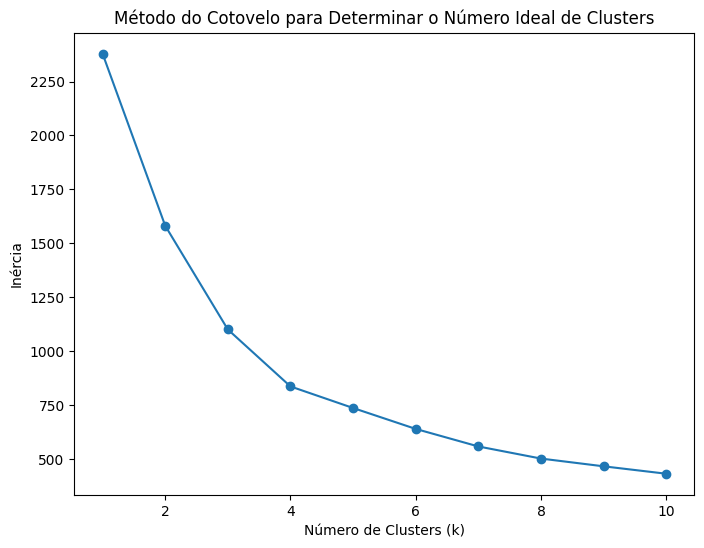

In [19]:
# Lista para armazenar a inércia para cada valor de k
inercia = []

# Testar de 1 a 10 clusters
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_df)
    inercia.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Determinar o Número Ideal de Clusters')
plt.show()

<span style="color: green;">Vamos usar o método do cotovelo para decidir quantos Clusters teremos, temos que ver onde a curva mais se assemelha a um cotovelo, por isso dividimos em 10 clusters e vamos escolher 4 onde tem mais diferenças entre eles </span>

## Vamos ver como fica a distribuição com 4 clusters, se for preciso mudamos pra 5

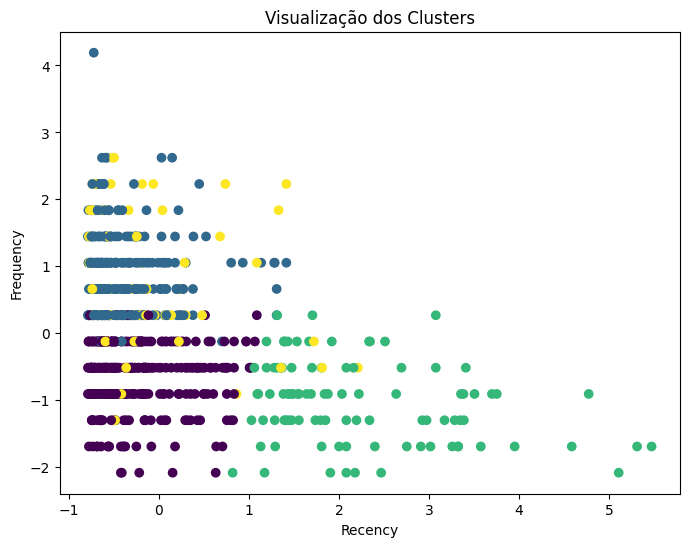

In [21]:
# Ajustando o modelo KMeans com 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(rfm_scaled_df)

# Adicionar os rótulos (labels) de cluster ao DataFrame
rfm_scaled_df['Cluster'] = kmeans.labels_

# Visualização dos clusters (se aplicável)
plt.figure(figsize=(8, 6))
plt.scatter(rfm_scaled_df['Recency'], rfm_scaled_df['Frequency'], c=rfm_scaled_df['Cluster'], cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Visualização dos Clusters')
plt.show()


<span style="color: green;">Aparentemente ficou bem ruim, mas estamos comparando duas variaveis (Frequencia e Recencia) num grafico 2D, talvez analisar um grafico 3D com as 3 variaveis nos de uma perspectiva melhor</span>

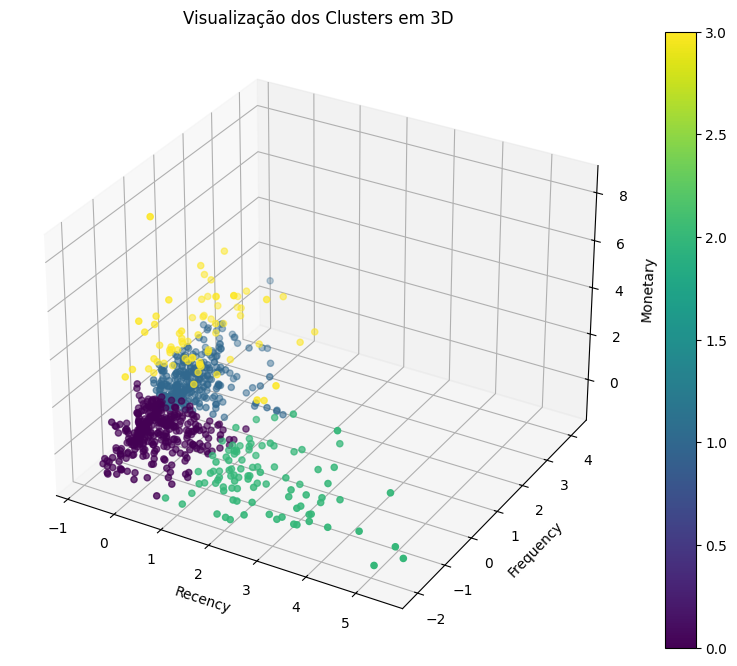

In [22]:
from mpl_toolkits.mplot3d import Axes3D

# Visualização dos clusters em 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotando os pontos 3D
sc = ax.scatter(rfm_scaled_df['Recency'], rfm_scaled_df['Frequency'], rfm_scaled_df['Monetary'], 
                c=rfm_scaled_df['Cluster'], cmap='viridis')

# Rótulos dos eixos
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

# Título do gráfico
ax.set_title('Visualização dos Clusters em 3D')

# Exibir a barra de cores
plt.colorbar(sc)

# Exibir o gráfico
plt.show()


<span style="color: green;">Agora ficou bem mais claro e podemos ver bem definidos os clusters, então fizemos uma boa escolha com 4 clusters</span>

## Vamos reverter a padronizaçao para criarmos os grupos de clientes

In [23]:
# Reverter a padronização
rfm_original = scaler.inverse_transform(rfm_scaled_df[['Recency', 'Frequency', 'Monetary']])

# Converter para DataFrame e adicionar as colunas originais
rfm_original = pd.DataFrame(rfm_original, columns=['Recency', 'Frequency', 'Monetary'])

# Adicionar a coluna 'Cluster' ao DataFrame revertido
rfm_original['Cluster'] = rfm_scaled_df['Cluster']

In [24]:
rfm_original.head()

,Recency,Frequency,Monetary,Cluster
0,184.0,5.0,5563.560,0
1,19.0,9.0,1056.390,1
2,259.0,4.0,1790.512,0
3,55.0,6.0,5086.935,1
4,415.0,3.0,886.156,2


## Vamos adicionar novamente o Customer ID que tinhamos removido para padronização

In [25]:
# Adicionar 'Customer ID' ao DataFrame revertido
rfm_original['Customer ID'] = rfm['Customer ID']
rfm_original.head()

,Recency,Frequency,Monetary,Cluster,Customer ID
0,184.0,5.0,5563.560,0,AA-10315
1,19.0,9.0,1056.390,1,AA-10375
2,259.0,4.0,1790.512,0,AA-10480
3,55.0,6.0,5086.935,1,AA-10645
4,415.0,3.0,886.156,2,AB-10015


In [27]:
rfm_original['Cluster'].value_counts()

Cluster
0    331
1    296
2     96
3     70
Name: count, dtype: int64

<span style="color: green;">Temos agora 4 grupos de clientes onde 0 é o grupo de melhores clientes, vamos trocar para A,B,C e D</span>

In [28]:
# Mapear os clusters para A, B, C, D, conforme solicitado
cluster_mapping = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
rfm_original['Group'] = rfm_original['Cluster'].map(cluster_mapping)

# Verificar a classificação final
rfm_original[['Customer ID', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'Group']].head()

,Customer ID,Recency,Frequency,Monetary,Cluster,Group
0,AA-10315,184.0,5.0,5563.560,0,A
1,AA-10375,19.0,9.0,1056.390,1,B
2,AA-10480,259.0,4.0,1790.512,0,A
3,AA-10645,55.0,6.0,5086.935,1,B
4,AB-10015,415.0,3.0,886.156,2,C


<span style="color: green;">Agora vamos adicionar a coluna Group no nosso dataset original</span>

In [29]:
# Agora, fazer um merge/join com o DataFrame original usando 'Customer ID'
df= pd.merge(df, rfm_original[['Customer ID', 'Group']], on='Customer ID', how='left')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Sales,Quantity,Discount,Profit,Unitary,Lucro_sem_desconto,Lucro_com_desconto,Order Month,Order Year,Group
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,...,261.9600,2,0.00,41.9136,130.98,0.16,0.16,11,2016,C
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,...,731.9400,3,0.00,219.5820,243.98,0.30,0.30,11,2016,C
2,3,CA-2016-138688,2016-06-12,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,Los Angeles,California,...,14.6200,2,0.00,6.8714,7.31,0.47,0.47,6,2016,A
3,4,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,...,957.5775,5,0.45,-383.0310,348.21,0.23,-0.22,10,2015,A
4,5,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,...,22.3680,2,0.20,2.5164,13.98,0.29,0.09,10,2015,A


<span style="color: green;">Temos agora cada cliente separado por seu grupo baseado na Frequencia, Recencia e Valor Monetario</span>

### Recomendações Para a Área de Negócio:

<span style="color: green;">GRUPO D</span> = Clientes Quase Perdidos - Fizeram algumas compras iniciais, mas não voltaram desde então. Foi uma experiência ruim para o cliente? Ou adequação ao mercado do produto? Vamos gastar alguns recursos para construir o conhecimento de nossa marca com eles?

<span style="color: green;">GRUPO C</span> = Clientes Que Precisam de Atenção - Mostrando sinais promissores com a quantidade e valor de sua compra, mas já faz um tempo que não compram. Vamos direcioná-los para seus itens da lista de desejos e um desconto com oferta por tempo limitado.


<span style="color: green;">GRUPO B</span> = Potenciais Clientes Leais - Alto potencial para entrar em nossos segmentos de clientes fiéis, por que não oferecer alguns brindes em sua próxima compra para mostrar que você os valoriza?

<span style="color: green;">GRUPO A</span> = Clientes Leais Que Compram com Frequência - É sempre uma boa ideia tratar cuidadosamente todos os novos clientes, mas como esses clientes gastaram muito em suas compras, são ainda mais valiosos. É importante fazer com que eles se sintam valorizados e apreciados - e dar-lhes incentivos incríveis para continuar a interagir com a marca.

In [30]:
#Salvar as modificações para usar no projeto 2
df.to_csv('df_final.csv', index=False, encoding='ISO-8859-1')

# FIM